In [1]:
# necessary imports
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from openood.evaluation_api import Evaluator
from openood.networks import ResNet18_32x32

In [2]:
import faiss
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

In [4]:
imagesize = 32

transform_test = transforms.Compose([
    transforms.Resize((imagesize, imagesize)),
    transforms.CenterCrop(imagesize),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
    # transforms.Normalize([x/255.0 for x in [125.3, 123.0, 113.9]],
    #                     [x/255.0 for x in [63.0, 62.1, 66.7]]),
])

transform_train = transforms.Compose([
    # transforms.RandomCrop(imagesize, padding=4),
    transforms.RandomResizedCrop(size=imagesize, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
    # transforms.Normalize([x / 255.0 for x in [125.3, 123.0, 113.9]],
    #                      [x / 255.0 for x in [63.0, 62.1, 66.7]]),
])

In [5]:
train_dir10 = './data/images_classic/cifar10/cifar10/train'
test_dir10 = './data/images_classic/cifar10/cifar10/test'
train_dir100 = './data/images_classic/cifar100/cifar100/train'
test_dir100 = './data/images_classic/cifar100/cifar100/test'

In [12]:
net = ResNet18_32x32(num_classes=10)
net.load_state_dict(
    torch.load('./results/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt')
)
net.cuda()
net.eval()

C:\Users\Zhao\AppData\Local\Temp\ipykernel_18368\1368810468.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('./results/cifar10_resnet18_32x32_base_e100_lr0.1_

ResNet18_32x32(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [6]:
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
])
transform_cifar100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761]),
])

In [9]:
datasets10 = {
    'train': datasets.ImageFolder(train_dir10, transform=transform_cifar10),
    'test': datasets.ImageFolder(test_dir10, transform=transform_cifar10)
}
datasets100 = {
    'train': datasets.ImageFolder(train_dir100, transform=transform_cifar100),
    'test': datasets.ImageFolder(test_dir100, transform=transform_cifar100)
}
dataloaders10 = {
    'train': DataLoader(datasets10['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(datasets10['test'], batch_size=64, shuffle=False, num_workers=4)
}
dataloaders100 = {
    'train': DataLoader(datasets100['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(datasets100['test'], batch_size=64, shuffle=False, num_workers=4)
}

In [10]:
dataloaders10 = {
    'train': DataLoader(datasets10['train'], batch_size=64, shuffle=True, num_workers=2),
    'test': DataLoader(datasets10['test'], batch_size=64, shuffle=False, num_workers=2)
}
dataloaders100 = {
    'train': DataLoader(datasets100['train'], batch_size=64, shuffle=True, num_workers=2),
    'test': DataLoader(datasets100['test'], batch_size=64, shuffle=False, num_workers=2)
}

## feat_extract

In [19]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
device = 'cuda' 

In [20]:
batch_size = 64

In [21]:
FORCE_RUN = False

In [22]:
# Normalizer function to ensure unit norm
normalizer = lambda x: x / np.linalg.norm(x, axis=-1, keepdims=True) + 1e-10

In [83]:
class KNNPostprocessor():
    def __init__(self, K):
        self.K = K
        self.activation_log = None

    def setup(self, net: nn.Module, id_loader_dict, ood_loader_dict):
            activation_log = []
            net.eval()
            with torch.no_grad():
                for batch in tqdm(id_loader_dict['train'],
                                  desc='Setup: ',
                                  position=0,
                                  leave=True):
                    data = batch[0].cuda()
                    data = data.float()

                    _, feature = net(data, return_feature=True)
                    activation_log.append(
                        normalizer(feature.data.cpu().numpy()))

            self.activation_log = np.concatenate(activation_log, axis=0)
            self.index = faiss.IndexFlatL2(feature.shape[1])
            self.index.add(self.activation_log)
    '''    def postprocess(self, net: nn.Module, data):
        output, feature = net(data, return_feature=True)
        feature_normed = normalizer(feature.data.cpu().numpy())
        D, _ = self.index.search(
            feature_normed,
            self.K,
        )
        kth_dist = -D[:, -1]
        _, pred = torch.max(torch.softmax(output, dim=1), dim=1)
        return pred, torch.from_numpy(kth_dist)'''
    def detect_ood(self, net: nn.Module, ood_loader):
        """
        Perform KNN-based OOD detection by computing distances to the nearest neighbors.
        
        Args:
        - net (nn.Module): The neural network model used for feature extraction.
        - ood_loader (DataLoader): DataLoader for the out-of-distribution (OOD) dataset (test data).

        Returns:
        - scores (torch.Tensor): OOD scores based on K-th nearest neighbor distances.
        """
        ood_scores = []
        net.eval()

        # Extract features for OOD samples and compute distances to nearest neighbors
        for batch in tqdm(ood_loader, desc='Processing OOD data', position=0, leave=True):
            data = batch[0].cuda()  # Get the input data and move to GPU
            _, feature = net(data, return_feature=True)  # Extract features

            # Normalize the features
            feature_normed = normalizer(feature.data.cpu().numpy())

            # Search K nearest neighbors and get distances
            D, _ = self.index.search(feature_normed, self.K)
            
            # Use the K-th distance as the OOD score
            kth_dist = -D[:, -1]  # Negative distance for consistency with OOD scoring
            ood_scores.append(torch.from_numpy(kth_dist))

        # Concatenate all OOD scores
        ood_scores = torch.cat(ood_scores, dim=0)
        return ood_scores
    def evaluate(self, id_loader, ood_loader, net):
        """
        Evaluate OOD detection performance by comparing ID and OOD samples.
        
        Args:
        - id_loader (DataLoader): DataLoader for the in-distribution dataset (test data).
        - ood_loader (DataLoader): DataLoader for the out-of-distribution dataset (test data).
        - net (nn.Module): The neural network model used for feature extraction.

        Returns:
        - fpr_at_95_tpr (float): False positive rate at 95% true positive rate.
        """
        # Extract ID and OOD features
        self.id_scores = self.detect_ood(net, id_loader)
        self.ood_scores = self.detect_ood(net, ood_loader)

        # Calculate FPR at 95% TPR
        fpr_at_95_tpr = self.calculate_fpr_at_95_tpr(self.id_scores, self.ood_scores)
        return fpr_at_95_tpr
    def calculate_fpr_at_95_tpr(self,id_scores, ood_scores):
        """
        Calculate FPR at 95% TPR for OOD detection.

        Args:
        - id_scores (torch.Tensor): Scores for in-distribution samples.
        - ood_scores (torch.Tensor): Scores for out-of-distribution samples.

        Returns:
        - fpr_at_95_tpr (float): False positive rate at 95% true positive rate.
        """
        labels = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
        scores = np.concatenate([id_scores, ood_scores])

        # Sort scores and labels based on the score threshold
        sorted_indices = np.argsort(scores)
        sorted_labels = labels[sorted_indices]

        # Calculate TPR and FPR
        tpr = np.cumsum(sorted_labels) / np.sum(sorted_labels)
        fpr = np.cumsum(1 - sorted_labels) / np.sum(1 - sorted_labels)

        # Find FPR where TPR is closest to 95%
        idx = np.searchsorted(tpr, 0.95)
        fpr_at_95_tpr = fpr[idx]
        return fpr_at_95_tpr

In [84]:
k50 = KNNPostprocessor(50)

In [85]:

# Setup Faiss index with in-distribution training data
k50.setup(net, dataloaders10,dataloaders100 )
# Evaluate OOD detection performance
fpr_at_95_tpr = k50.evaluate(dataloaders10['test'], dataloaders100['test'], net)
print(f"FPR at 95% TPR: {fpr_at_95_tpr:.4f}")

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 157/157 [02:56<00:00,  1.13s/it]

FPR at 95% TPR: 0.3795


In [65]:
def calculate_fpr_at_95_tpr(id_scores, ood_scores):
    """
    Calculate FPR@95TPR.
    
    Args:
        id_scores (list): Distance scores for in-distribution data.
        ood_scores (list): Distance scores for out-of-distribution data.
    
    Returns:
        fpr_at_95_tpr (float): False Positive Rate at 95% True Positive Rate.
    """
    # Create labels for ID (1) and OOD (0)
    labels = np.concatenate([np.ones(len(id_scores)), np.zeros(len(ood_scores))])

    # Concatenate the scores (distances)
    scores = np.concatenate([id_scores, ood_scores])

    # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
    fpr, tpr, thresholds = roc_curve(labels, -scores)  # Negative scores because smaller distances = higher confidence

    # Find the threshold where TPR is closest to 95%
    index_95_tpr = np.where(tpr >= 0.95)[0][0]

    # FPR at the threshold where TPR is 95%
    fpr_at_95_tpr = fpr[index_95_tpr]

    return fpr_at_95_tpr

In [62]:
k50.id_scores,k50.ood_scores

(tensor([-0.0368, -0.0746, -0.0197,  ..., -0.0132, -0.0180, -0.0111]),
 tensor([-0.4240, -0.2318, -0.2776,  ..., -0.3427, -0.0591, -0.0288]))

In [71]:
id_mean = k50.id_scores.mean().item()
ood_mean = k50.ood_scores.mean().item()

In [72]:
ood_mean,id_mean

(-0.19349592924118042, -0.049229297786951065)

In [67]:
from sklearn.metrics import roc_curve

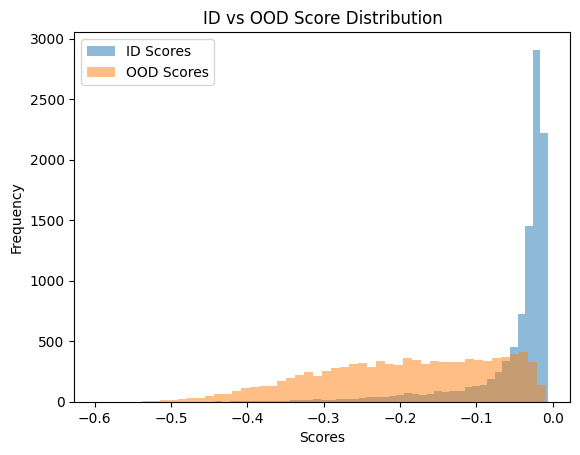

In [75]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays if in PyTorch tensor format
id_scores_np = k50.id_scores.cpu().numpy() if isinstance(k50.id_scores, torch.Tensor) else id_scores
ood_scores_np = k50.ood_scores.cpu().numpy() if isinstance(k50.ood_scores, torch.Tensor) else ood_scores

plt.hist(id_scores_np, bins=50, alpha=0.5, label='ID Scores')
plt.hist(ood_scores_np, bins=50, alpha=0.5, label='OOD Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.legend()
plt.title('ID vs OOD Score Distribution')
plt.show()

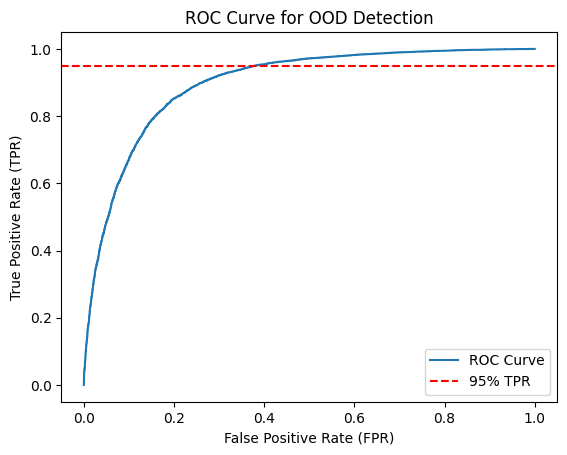

In [82]:
import matplotlib.pyplot as plt

labels = np.concatenate([np.zeros(len(k50.id_scores)), np.ones(len(k50.ood_scores))])
scores = np.concatenate([k50.id_scores, k50.ood_scores])

fpr, tpr, thresholds = roc_curve(labels, -scores)
plt.plot(fpr, tpr, label='ROC Curve')
plt.axhline(0.95, color='red', linestyle='--', label='95% TPR')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.title('ROC Curve for OOD Detection')
plt.show()

In [86]:
k10 = KNNPostprocessor(10)
# Setup Faiss index with in-distribution training data
k10.setup(net, dataloaders10,dataloaders100 )
# Evaluate OOD detection performance
fpr_at_95_tpr = k10.evaluate(dataloaders10['test'], dataloaders100['test'], net)
print(f"FPR at 95% TPR: {fpr_at_95_tpr:.4f}")

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 157/157 [02:56<00:00,  1.12s/it]

FPR at 95% TPR: 0.3828


In [ ]:
k100 = KNNPostprocessor(10)
# Setup Faiss index with in-distribution training data
k100.setup(net, dataloaders10,dataloaders100 )
# Evaluate OOD detection performance
fpr_at_95_tpr = k100.evaluate(dataloaders10['test'], dataloaders100['test'], net)
print(f"FPR at 95% TPR: {fpr_at_95_tpr:.4f}")

Processing OOD data:  69%|████████████████████████████████████████▌                  | 108/157 [02:02<00:55,  1.14s/it]